<a href="https://colab.research.google.com/github/RadiotherapyAI/unet-workshop/blob/main/unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# U-Net Workshop

Here is an example 2D U-Net implementation using minified data based upon creative commons dataset available at https://wiki.cancerimagingarchive.net/display/Public/HNSCC.

In [1]:
# Copyright 2022 Radiotherapy AI Pty Ltd

# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at

#    http://www.apache.org/licenses/LICENSE-2.0

# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

## Overview

* Investigate what is possible
* Creating a data pipeline
* Displaying the data
* Building a UNet
* Set up data display to work during training
* Training the model

In [2]:
# First things first, describe the Google Colab interface
# Make sure everyone can run a hello world.

## What is possible

In [1]:
!pip install rai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.6/145.6 kB 3.3 MB/s eta 0:00:000:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.7/33.7 MB 6.1 MB/s eta 0:00:00m eta 0:00:010:00:01
  Using cached Shapely-1.8.4-cp310-cp310-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (2.0 MB)
  Using cached scikit_image-0.19.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (13.9 MB)
  Using cached pydicom-2.3.0-py3-none-any.whl (2.0 MB)
  Using cached click-8.1.3-py3-none-any.whl (96 kB)
  Using cached networkx-2.8.7-py3-none-any.whl (2.0 MB)
  Using cached tifffile-2022.8.12-py3-none-any.whl (208 kB)
  Using cached imageio-2.22.1-py3-none-any.whl (3.4 MB)
  Using cached PyWavelets-1.4.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (6.8 MB)

[notice] A new release of pip available: 22.2.1 -> 22.2.2
[notice] To update, run: pip3 install --upgrade pip
Reshimming asdf python...


In [ ]:
# TODO: Show the rai model in action

## Library imports

Here are a set of library imports, from both the standard library and some libraries downloadable from PyPI. These are imported within namespaces so as not to variable and function name conflicts.

In [4]:
import pathlib
import random
import shutil
import urllib.request

import imageio
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

## Constants

In [6]:
BATCH_SIZE = 512
GRID_SIZE = 64

DATASET_TYPES = {"hold-out", "training", "validation"}

COLOURS_AND_LABELS = [
    ("#ff7f0e", "left parotid"),
    ("#2ca02c", "right parotid"),
    ("#d62728", "external"),
]
NUM_CONTOURS = len(COLOURS_AND_LABELS)

In [7]:
IMAGE_DIMENSIONS = (GRID_SIZE, GRID_SIZE, 1)
MASK_DIMENSIONS = (GRID_SIZE, GRID_SIZE, NUM_CONTOURS)

In [9]:
EXPECTED_BATCH_IMAGE_DIMENSIONS = (
    BATCH_SIZE,
    *IMAGE_DIMENSIONS,
)
EXPECTED_BATCH_MASK_DIMENSIONS = (
    BATCH_SIZE,
    *MASK_DIMENSIONS,
)

## Download and investigate the data

In [11]:
zip_url = (
    "https://github.com/RadiotherapyAI/"
    "unet-workshop/releases/download/"
    "mini-parotid/mini-parotid.zip"
)
zip_url

'https://github.com/RadiotherapyAI/unet-workshop/releases/download/mini-parotid/mini-parotid.zip'

In [12]:
# Investigate the downloadable data within a filebrowser

In [13]:
zip_filepath = "data.zip"

data_directory = pathlib.Path("data")

if not data_directory.exists():
    urllib.request.urlretrieve(zip_url, zip_filepath)
    shutil.unpack_archive(zip_filepath, data_directory)

In [14]:
# Investigate the downloaded data with pathlib and glob
# Load an image with imageio and create a plot with
# matplotlib's imshow

## After demo -- BREAKOUT ROOMS -- gather feedback on tutorial's pace ##
# -- GOAL: Have everyone able to plot
#          the downloaded data, demoed first

In [15]:
dataset_types_found = {
    path.name
    for path in data_directory.glob("*")
    if path.is_dir()
}

# Don't assume it, prove it
assert dataset_types_found == DATASET_TYPES

## Build the TensorFlow pipeline

In [16]:
def get_image_paths(dataset_type):
    image_paths = list(
        (data_directory / dataset_type).glob(
            "*/*.image.png"
        )
    )

    return image_paths

In [17]:
# Explain the components of a function definition, inputs/outputs
# Demo the usage of this function
# Find the number of image paths for each dataset type

In [18]:
def get_path_pairs(dataset_type):
    image_paths = get_image_paths(dataset_type)
    mask_paths = [
        path.parent / f"{path.name.split('.')[0]}.masks.png"
        for path in image_paths
    ]

    path_pairs = [
        (str(image), str(mask))
        for image, mask in zip(
            image_paths,
            mask_paths,
        )
    ]

    return sorted(path_pairs)

In [19]:
@tf.function
def load(path_pair):
    image_path = path_pair[0]
    masks_path = path_pair[1]

    image_raw = tf.io.read_file(image_path)
    image = tf.io.decode_image(
        image_raw, channels=1, dtype=tf.uint8
    )

    masks_raw = tf.io.read_file(masks_path)
    masks = tf.io.decode_image(
        masks_raw, channels=NUM_CONTOURS, dtype=tf.uint8
    )

    return image / 255, masks / 255

In [20]:
def create_datasets(dataset_type):
    path_pairs = get_path_pairs(dataset_type)
    dataset = tf.data.Dataset.from_tensor_slices(path_pairs)
    dataset = dataset.shuffle(
        len(path_pairs),
        reshuffle_each_iteration=True,
    )
    dataset = dataset.map(load)

    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset

In [21]:
datasets = {}

for dataset_type in DATASET_TYPES:
    datasets[dataset_type] = create_datasets(dataset_type)

datasets

{'hold-out': <PrefetchDataset shapes: (<unknown>, <unknown>), types: (tf.float32, tf.float32)>,
 'training': <PrefetchDataset shapes: (<unknown>, <unknown>), types: (tf.float32, tf.float32)>,
 'validation': <PrefetchDataset shapes: (<unknown>, <unknown>), types: (tf.float32, tf.float32)>}

## Investigate the created pipeline

In [27]:
batch_validation_images, batch_validation_masks = iter(
    datasets["validation"].take(1)
).next()

In [29]:
image = batch_validation_images[0, ...]
masks = batch_validation_masks[0, ...]

In [30]:
# Investigate the shapes of the newly indexed objects

In [31]:
# Use imshow to view these images and masks

## Create a useful representation of the data

In [32]:
def plot_contours(ax, image, masks):
    ax.imshow(image[:, :, 0], cmap="gray")

    for i, (colour, label) in enumerate(COLOURS_AND_LABELS):
        if np.all(masks[..., i] < 0.5) or np.all(
            masks[..., i] > 0.5
        ):
            continue

        c = ax.contour(
            masks[..., i],
            colors=[colour],
            levels=[0.5],
        )
        c.collections[0].set_label(label)

    ax.axis("equal")
    ax.legend()

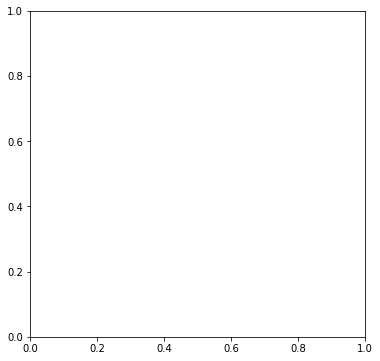

In [33]:
fig, ax = plt.subplots(figsize=(6, 6))
# Use the plot_contours function

## BREAKOUT ROOMS ##
# -- Goal: Everyone able to investigate the validation images and masks

## Building the 2D U-Net model

In this section we will create a Tensorflow Keras 2D UNet model utilising a set of pre-built functions. An example UNet diagram is given below for aiding explanation:

![](https://github.com/RadiotherapyAI/unet-workshop/blob/019f25013030e51b83e2370b347bf5933aebc37c/images/unet.png?raw=1)

In [ ]:
def activation(x):
    x = tf.keras.layers.Activation("relu")(x)

    return x

In [34]:



def convolution(x, number_of_filters, kernel_size=3):
    x = tf.keras.layers.Conv2D(
        number_of_filters,
        kernel_size,
        padding="same",
        kernel_initializer="he_normal",
    )(x)

    return x


def conv_transpose(x, number_of_filters, kernel_size=3):
    x = tf.keras.layers.Conv2DTranspose(
        number_of_filters,
        kernel_size,
        strides=2,
        padding="same",
        kernel_initializer="he_normal",
    )(x)

    return x

In [35]:
# Highlight where the activation, convolution, and conv_transpose occurs in the UNet diagram

In [36]:
def encode(
    x,
    number_of_filters,
    number_of_convolutions=2,
):
    """An encoding layer within a 2D UNet"""
    for _ in range(number_of_convolutions):
        x = convolution(x, number_of_filters)
        x = activation(x)
    skip = x

    x = tf.keras.layers.MaxPool2D()(x)
    x = activation(x)

    return x, skip


def decode(
    x,
    skip,
    number_of_filters,
    number_of_convolutions=2,
):
    """A decoding layer within a 2D UNet"""
    x = conv_transpose(x, number_of_filters)
    x = activation(x)

    x = tf.keras.layers.concatenate([skip, x], axis=-1)

    for _ in range(number_of_convolutions):
        x = convolution(x, number_of_filters)
        x = activation(x)

    return x

In [37]:
# Highlight the encode and decode sections of the UNet

In [38]:
def get_unet_filter_counts(grid_size):
    """Return a reasonable set of convolution filter sizes for a UNet"""
    network_depth = int(np.log2(grid_size / 8))
    encoding_filter_counts = 2 ** (
        np.array(range(network_depth)) + 5
    )
    decoding_filter_counts = (
        2 ** (np.array(range(network_depth)) + 6)[::-1]
    )

    return (
        encoding_filter_counts,
        decoding_filter_counts,
    )

In [39]:
# Show the effect of a range of different grid_sizes

In [40]:
def unet(grid_size, num_contours):
    """Create a bare-bones 2D UNet"""
    inputs = tf.keras.layers.Input(
        (grid_size, grid_size, 1)
    )

    (
        encoding_filter_counts,
        decoding_filter_counts,
    ) = get_unet_filter_counts(grid_size)

    x = inputs
    skips = []

    for number_of_filters in encoding_filter_counts:
        x, skip = encode(x, number_of_filters)
        skips.append(skip)

    skips.reverse()

    for number_of_filters, skip in zip(
        decoding_filter_counts, skips
    ):
        x = decode(x, skip, number_of_filters)

    x = tf.keras.layers.Conv2D(
        num_contours,
        1,
        activation="sigmoid",
        padding="same",
        kernel_initializer="he_normal",
    )(x)

    model = tf.keras.Model(inputs=inputs, outputs=x)

    return model

In [41]:
model = unet(GRID_SIZE, NUM_CONTOURS)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 64, 64, 32)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 32)   9248        activation[0][0]                 
______________________________________________________________________________________________

In [42]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[
        tf.keras.metrics.BinaryAccuracy(),
        tf.keras.metrics.Recall(),
        tf.keras.metrics.Precision(),
    ],
)

In [43]:
# Utilise the untrained model to create a prediction

In [44]:
# Use the previously defined plot_contour to show this prediction

In [45]:
def plot_with_prediction(image, masks, pred_masks):
    fig, ax = plt.subplots(figsize=(12, 6), ncols=2)
    plot_contours(ax[0], image, masks)
    plot_contours(ax[1], image, pred_masks)

In [46]:
# Use this new function, plot_with_prediction, to see a comparison

In [47]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        pred_masks = model.predict(image[None, ...])[0, ...]
        plot_with_prediction(image, masks, pred_masks)

        plt.show()
        print(
            "\nSample Prediction after"
            " epoch {}\n".format(epoch + 1)
        )

In [48]:
# Describe classes
# Instantiate this callback class and
# call the on_epoch_end method to see what it does

## Training

In [49]:
# Swap to GPU runtime
# Run all cells

Epoch 1/50
4/4 [==============================] - 47s 7s/step - loss: 0.5820 - binary_accuracy: 0.7233 - recall: 0.7267 - precision: 0.3164 - val_loss: 0.4232 - val_binary_accuracy: 0.8570 - val_recall: 6.1750e-04 - val_precision: 0.7036


No handles with labels found to put in legend.


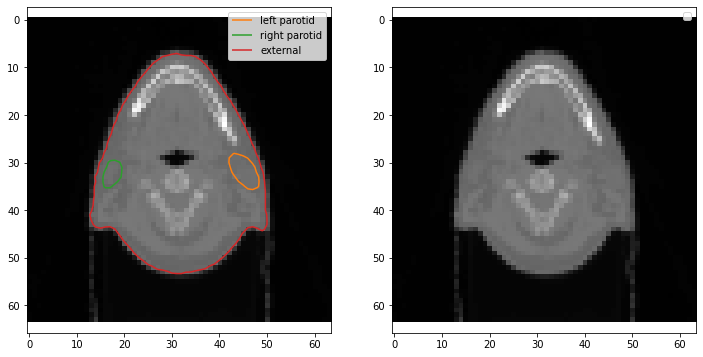


Sample Prediction after epoch 1

Epoch 2/50
4/4 [==============================] - 4s 1s/step - loss: 0.4314 - binary_accuracy: 0.8625 - recall: 0.0503 - precision: 0.9892 - val_loss: 0.3127 - val_binary_accuracy: 0.8614 - val_recall: 0.0373 - val_precision: 0.9125


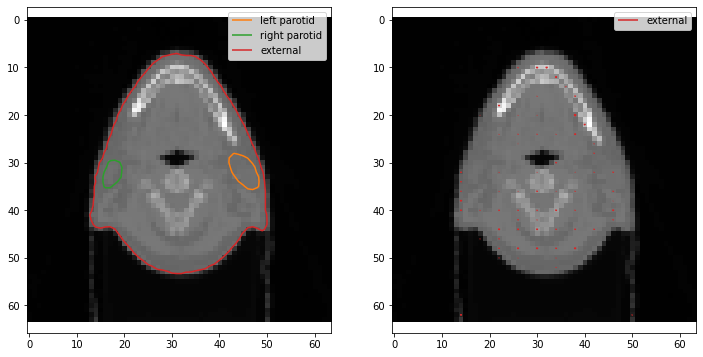


Sample Prediction after epoch 2

Epoch 3/50
4/4 [==============================] - 4s 999ms/step - loss: 0.2884 - binary_accuracy: 0.8745 - recall: 0.4434 - precision: 0.6161 - val_loss: 0.2208 - val_binary_accuracy: 0.9462 - val_recall: 0.9259 - val_precision: 0.8066


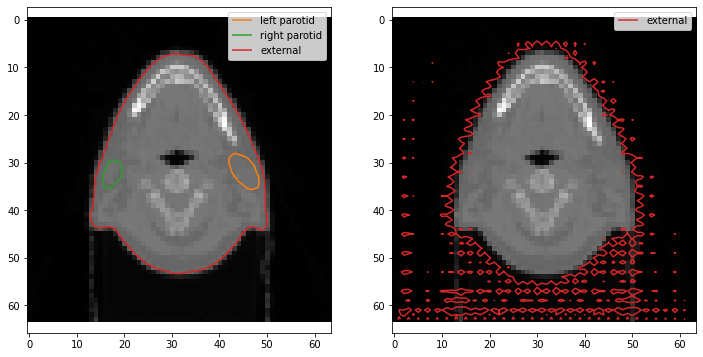


Sample Prediction after epoch 3

Epoch 4/50
4/4 [==============================] - 4s 1s/step - loss: 0.1768 - binary_accuracy: 0.9486 - recall: 0.7471 - precision: 0.9129 - val_loss: 0.1041 - val_binary_accuracy: 0.9715 - val_recall: 0.8161 - val_precision: 0.9983


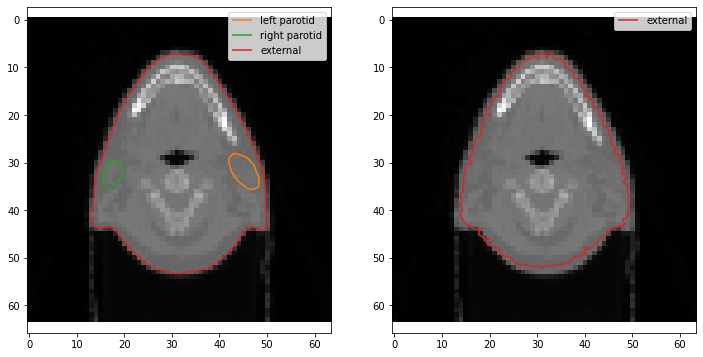


Sample Prediction after epoch 4

Epoch 5/50
4/4 [==============================] - 4s 1s/step - loss: 0.0892 - binary_accuracy: 0.9723 - recall: 0.8332 - precision: 0.9964 - val_loss: 0.0617 - val_binary_accuracy: 0.9771 - val_recall: 0.9005 - val_precision: 0.9893


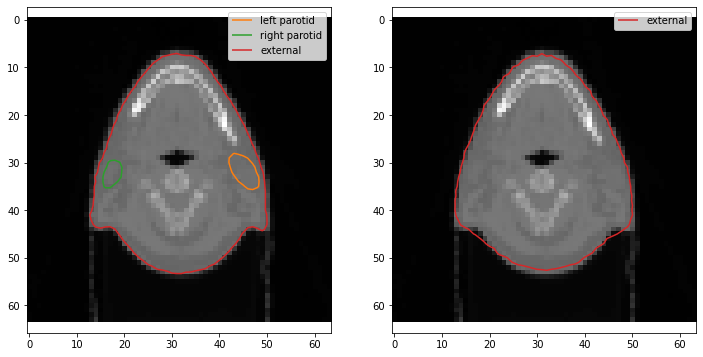


Sample Prediction after epoch 5

Epoch 6/50
4/4 [==============================] - 4s 1s/step - loss: 0.0586 - binary_accuracy: 0.9762 - recall: 0.8955 - precision: 0.9894 - val_loss: 0.0504 - val_binary_accuracy: 0.9770 - val_recall: 0.8957 - val_precision: 0.9910


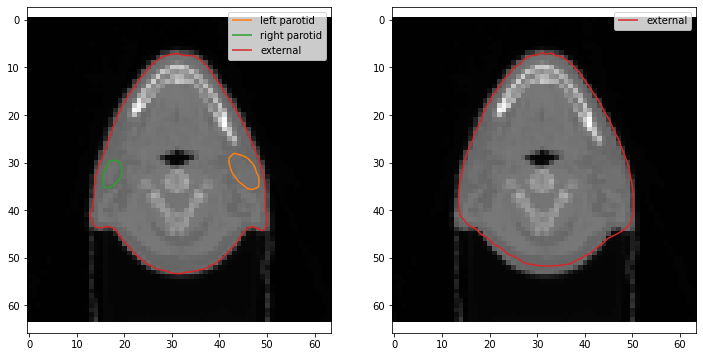


Sample Prediction after epoch 6

Epoch 7/50
4/4 [==============================] - 4s 1s/step - loss: 0.0493 - binary_accuracy: 0.9768 - recall: 0.9016 - precision: 0.9903 - val_loss: 0.0464 - val_binary_accuracy: 0.9776 - val_recall: 0.9146 - val_precision: 0.9879


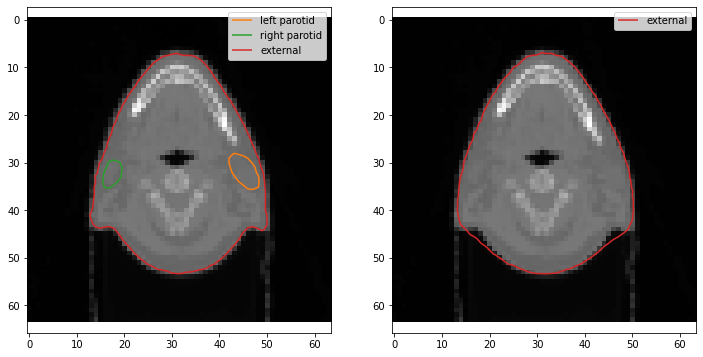


Sample Prediction after epoch 7

Epoch 8/50
4/4 [==============================] - 4s 1s/step - loss: 0.0464 - binary_accuracy: 0.9773 - recall: 0.9092 - precision: 0.9913 - val_loss: 0.0448 - val_binary_accuracy: 0.9780 - val_recall: 0.9020 - val_precision: 0.9920


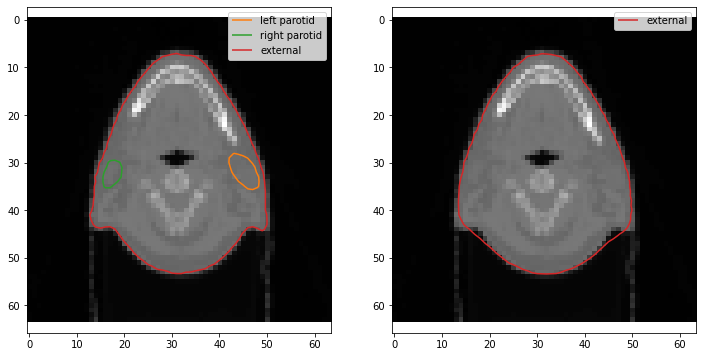


Sample Prediction after epoch 8

Epoch 9/50
4/4 [==============================] - 4s 1s/step - loss: 0.0444 - binary_accuracy: 0.9776 - recall: 0.9040 - precision: 0.9929 - val_loss: 0.0435 - val_binary_accuracy: 0.9777 - val_recall: 0.9186 - val_precision: 0.9889


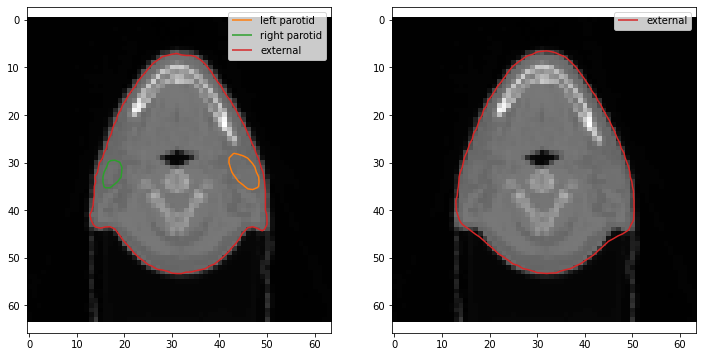


Sample Prediction after epoch 9

Epoch 10/50
4/4 [==============================] - 4s 1s/step - loss: 0.0430 - binary_accuracy: 0.9774 - recall: 0.9050 - precision: 0.9921 - val_loss: 0.0429 - val_binary_accuracy: 0.9776 - val_recall: 0.9166 - val_precision: 0.9881


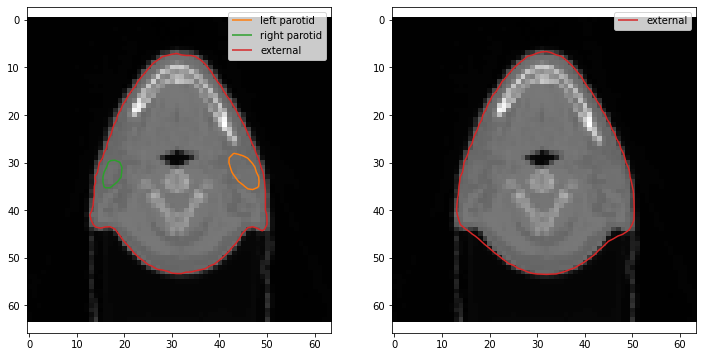


Sample Prediction after epoch 10

Epoch 11/50
4/4 [==============================] - 4s 1s/step - loss: 0.0423 - binary_accuracy: 0.9776 - recall: 0.9031 - precision: 0.9927 - val_loss: 0.0407 - val_binary_accuracy: 0.9779 - val_recall: 0.9084 - val_precision: 0.9922


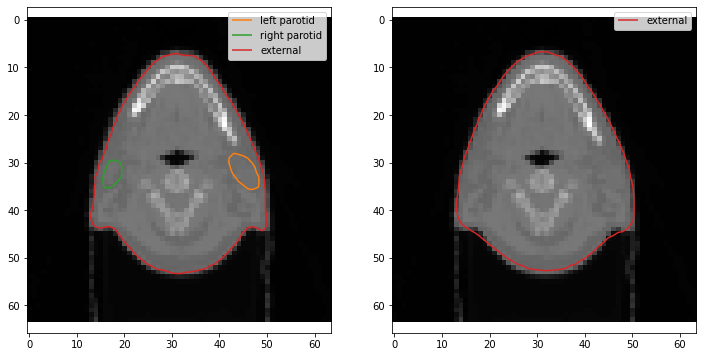


Sample Prediction after epoch 11

Epoch 12/50
4/4 [==============================] - 4s 1s/step - loss: 0.0402 - binary_accuracy: 0.9776 - recall: 0.9012 - precision: 0.9942 - val_loss: 0.0394 - val_binary_accuracy: 0.9780 - val_recall: 0.9079 - val_precision: 0.9921


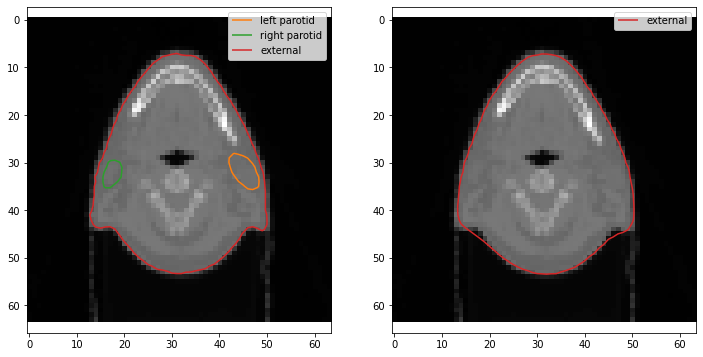


Sample Prediction after epoch 12

Epoch 13/50
4/4 [==============================] - 4s 1s/step - loss: 0.0387 - binary_accuracy: 0.9777 - recall: 0.9006 - precision: 0.9944 - val_loss: 0.0379 - val_binary_accuracy: 0.9781 - val_recall: 0.9121 - val_precision: 0.9923


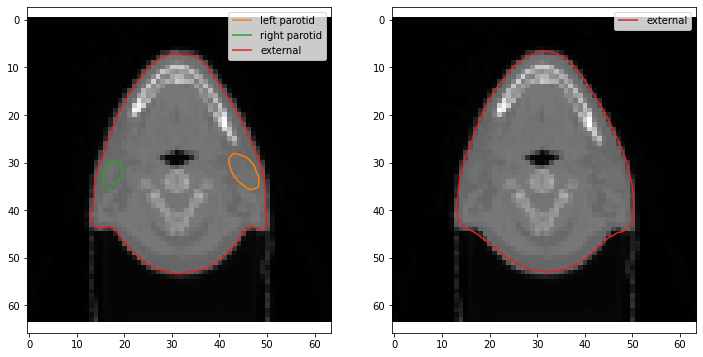


Sample Prediction after epoch 13

Epoch 14/50
4/4 [==============================] - 4s 1s/step - loss: 0.0373 - binary_accuracy: 0.9778 - recall: 0.9018 - precision: 0.9945 - val_loss: 0.0366 - val_binary_accuracy: 0.9781 - val_recall: 0.9070 - val_precision: 0.9929


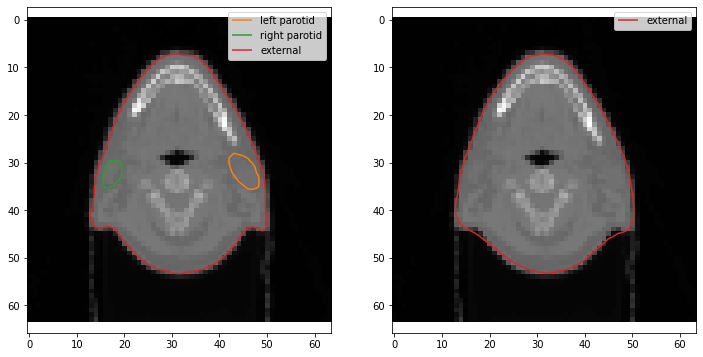


Sample Prediction after epoch 14

Epoch 15/50
4/4 [==============================] - 4s 1s/step - loss: 0.0360 - binary_accuracy: 0.9778 - recall: 0.9042 - precision: 0.9945 - val_loss: 0.0351 - val_binary_accuracy: 0.9784 - val_recall: 0.9018 - val_precision: 0.9946


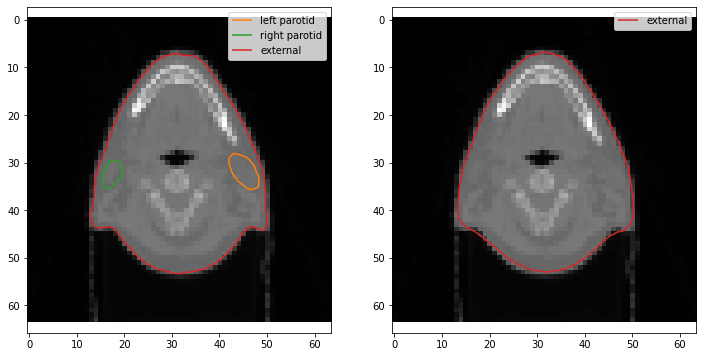


Sample Prediction after epoch 15

Epoch 16/50
4/4 [==============================] - 4s 1s/step - loss: 0.0346 - binary_accuracy: 0.9780 - recall: 0.9034 - precision: 0.9951 - val_loss: 0.0337 - val_binary_accuracy: 0.9784 - val_recall: 0.9018 - val_precision: 0.9944


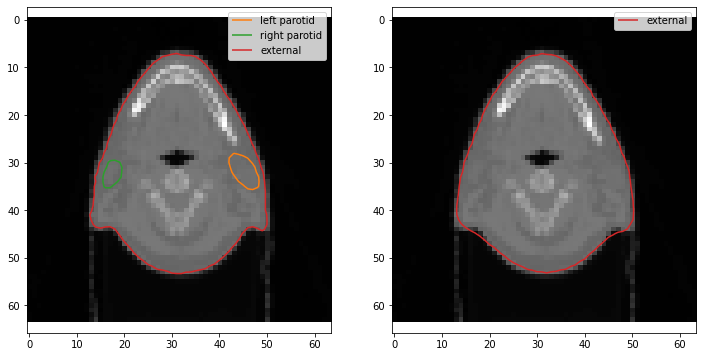


Sample Prediction after epoch 16

Epoch 17/50
4/4 [==============================] - 4s 1s/step - loss: 0.0331 - binary_accuracy: 0.9780 - recall: 0.9022 - precision: 0.9950 - val_loss: 0.0322 - val_binary_accuracy: 0.9784 - val_recall: 0.9069 - val_precision: 0.9941


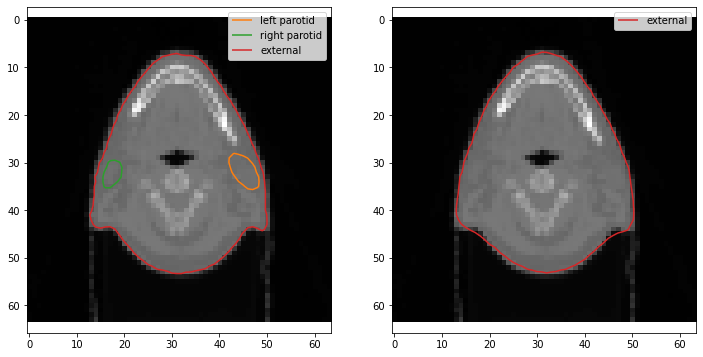


Sample Prediction after epoch 17

Epoch 18/50
4/4 [==============================] - 4s 1s/step - loss: 0.0315 - binary_accuracy: 0.9781 - recall: 0.9024 - precision: 0.9954 - val_loss: 0.0308 - val_binary_accuracy: 0.9784 - val_recall: 0.9095 - val_precision: 0.9939


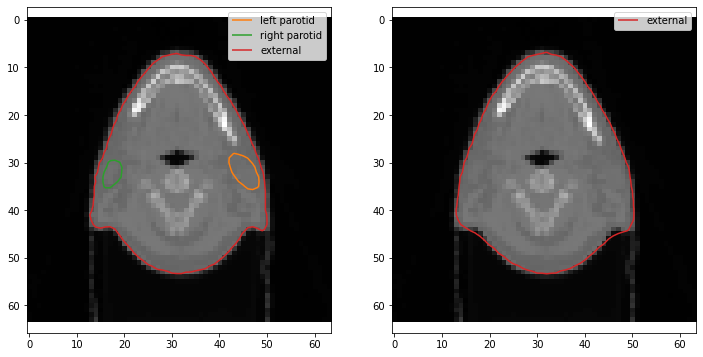


Sample Prediction after epoch 18

Epoch 19/50
4/4 [==============================] - 4s 1s/step - loss: 0.0297 - binary_accuracy: 0.9781 - recall: 0.9025 - precision: 0.9955 - val_loss: 0.0290 - val_binary_accuracy: 0.9787 - val_recall: 0.9017 - val_precision: 0.9955


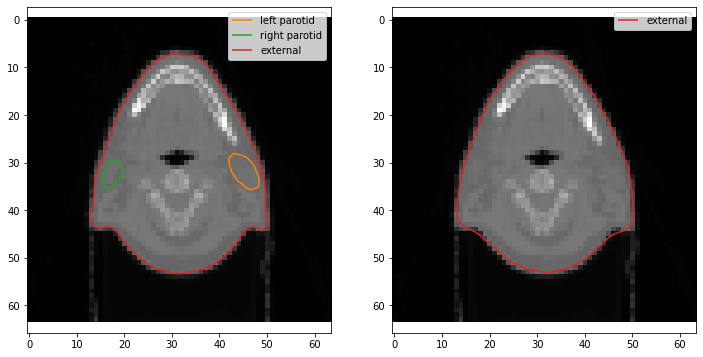


Sample Prediction after epoch 19

Epoch 20/50
4/4 [==============================] - 4s 1s/step - loss: 0.0281 - binary_accuracy: 0.9782 - recall: 0.9014 - precision: 0.9960 - val_loss: 0.0276 - val_binary_accuracy: 0.9787 - val_recall: 0.9051 - val_precision: 0.9954


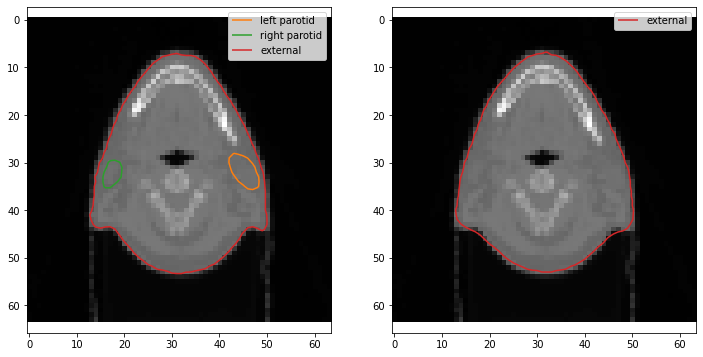


Sample Prediction after epoch 20

Epoch 21/50
4/4 [==============================] - 4s 1s/step - loss: 0.0387 - binary_accuracy: 0.9763 - recall: 0.8941 - precision: 0.9916 - val_loss: 0.1189 - val_binary_accuracy: 0.9582 - val_recall: 0.9483 - val_precision: 0.8647


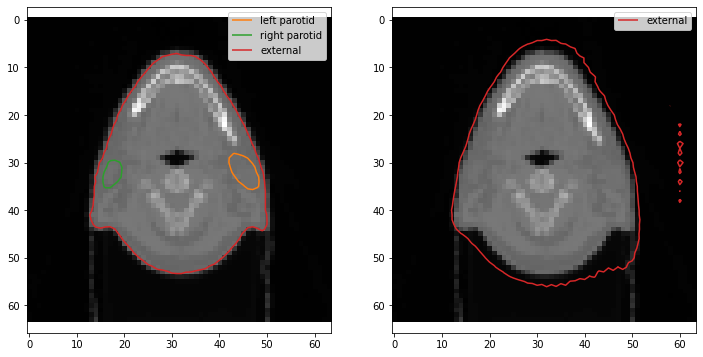


Sample Prediction after epoch 21

Epoch 22/50
4/4 [==============================] - 4s 1s/step - loss: 0.1050 - binary_accuracy: 0.9616 - recall: 0.9473 - precision: 0.8875 - val_loss: 0.0492 - val_binary_accuracy: 0.9763 - val_recall: 0.9103 - val_precision: 0.9823


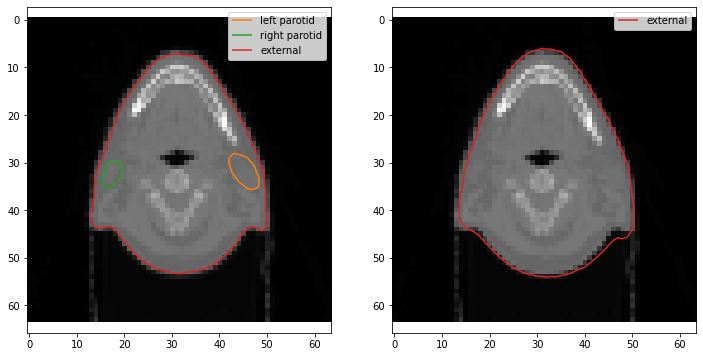


Sample Prediction after epoch 22

Epoch 23/50
4/4 [==============================] - 4s 1s/step - loss: 0.0520 - binary_accuracy: 0.9757 - recall: 0.8802 - precision: 0.9913 - val_loss: 0.0529 - val_binary_accuracy: 0.9768 - val_recall: 0.9153 - val_precision: 0.9889


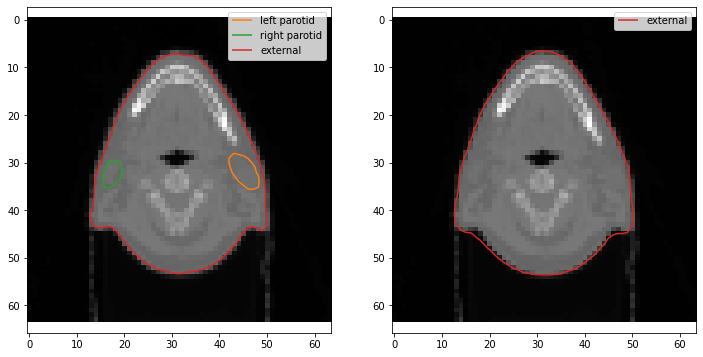


Sample Prediction after epoch 23

Epoch 24/50
4/4 [==============================] - 4s 1s/step - loss: 0.0503 - binary_accuracy: 0.9764 - recall: 0.9169 - precision: 0.9901 - val_loss: 0.0436 - val_binary_accuracy: 0.9772 - val_recall: 0.8974 - val_precision: 0.9945


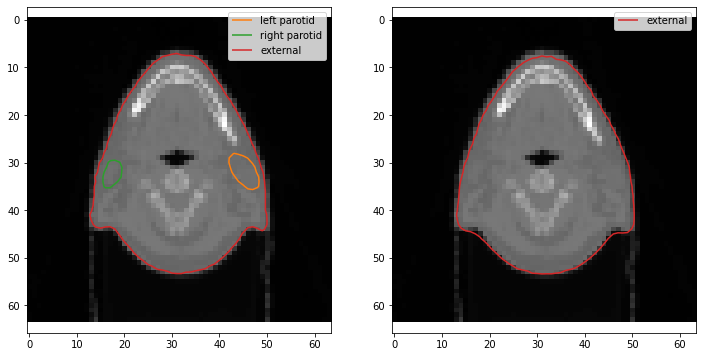


Sample Prediction after epoch 24

Epoch 25/50
4/4 [==============================] - 4s 1s/step - loss: 0.0435 - binary_accuracy: 0.9768 - recall: 0.8878 - precision: 0.9962 - val_loss: 0.0406 - val_binary_accuracy: 0.9776 - val_recall: 0.9006 - val_precision: 0.9952


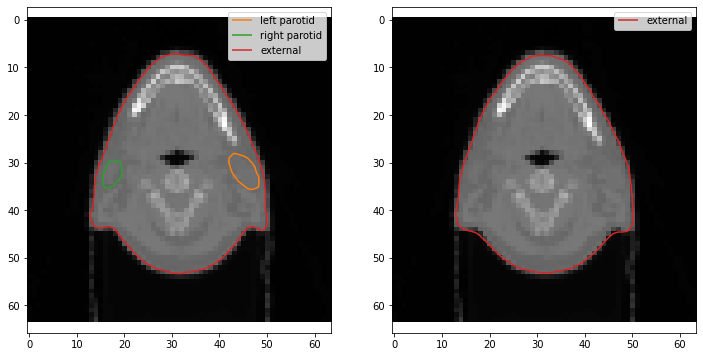


Sample Prediction after epoch 25

Epoch 26/50
4/4 [==============================] - 4s 1s/step - loss: 0.0408 - binary_accuracy: 0.9772 - recall: 0.9032 - precision: 0.9952 - val_loss: 0.0402 - val_binary_accuracy: 0.9776 - val_recall: 0.9022 - val_precision: 0.9945


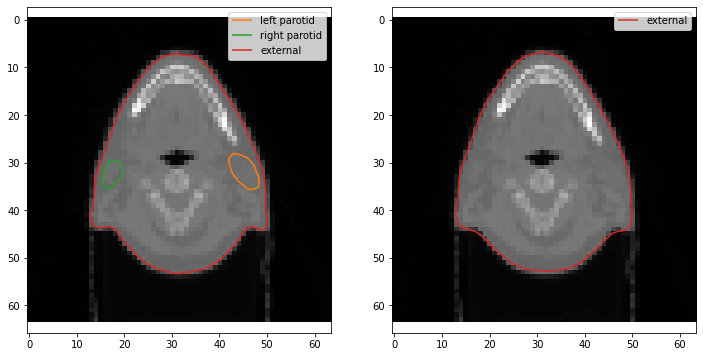


Sample Prediction after epoch 26

Epoch 27/50
4/4 [==============================] - 4s 1s/step - loss: 0.0399 - binary_accuracy: 0.9773 - recall: 0.8970 - precision: 0.9955 - val_loss: 0.0387 - val_binary_accuracy: 0.9778 - val_recall: 0.9006 - val_precision: 0.9947


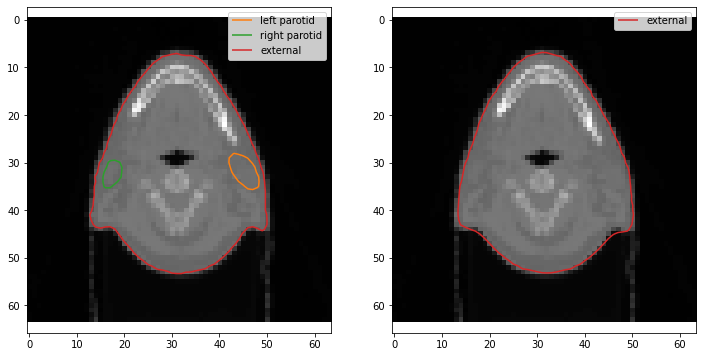


Sample Prediction after epoch 27

Epoch 28/50
4/4 [==============================] - 4s 1s/step - loss: 0.0385 - binary_accuracy: 0.9774 - recall: 0.9023 - precision: 0.9948 - val_loss: 0.0372 - val_binary_accuracy: 0.9781 - val_recall: 0.9006 - val_precision: 0.9950


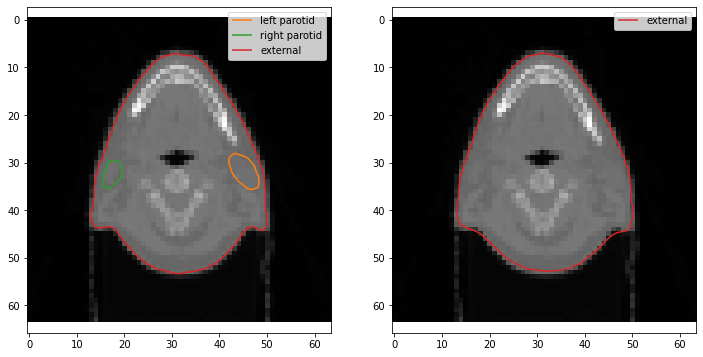


Sample Prediction after epoch 28

Epoch 29/50
4/4 [==============================] - 4s 1s/step - loss: 0.0371 - binary_accuracy: 0.9777 - recall: 0.8972 - precision: 0.9959 - val_loss: 0.0362 - val_binary_accuracy: 0.9782 - val_recall: 0.9046 - val_precision: 0.9948


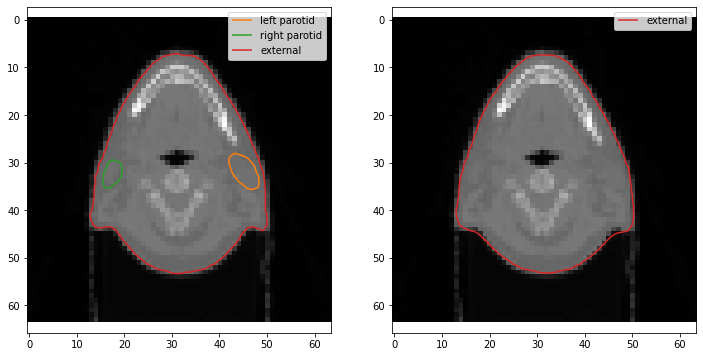


Sample Prediction after epoch 29

Epoch 30/50
4/4 [==============================] - 4s 1s/step - loss: 0.0358 - binary_accuracy: 0.9778 - recall: 0.9016 - precision: 0.9957 - val_loss: 0.0347 - val_binary_accuracy: 0.9783 - val_recall: 0.9011 - val_precision: 0.9956


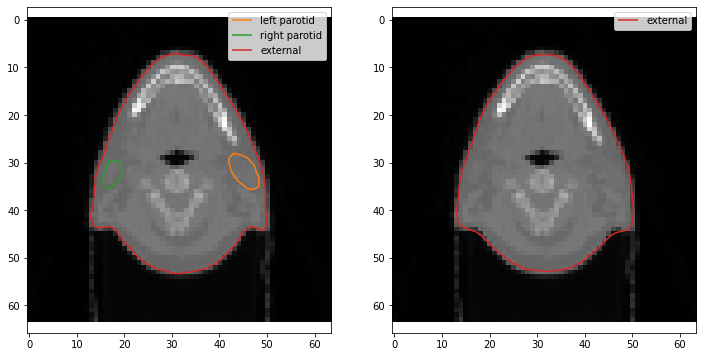


Sample Prediction after epoch 30

Epoch 31/50
4/4 [==============================] - 4s 1s/step - loss: 0.0343 - binary_accuracy: 0.9779 - recall: 0.9001 - precision: 0.9963 - val_loss: 0.0331 - val_binary_accuracy: 0.9785 - val_recall: 0.9025 - val_precision: 0.9958


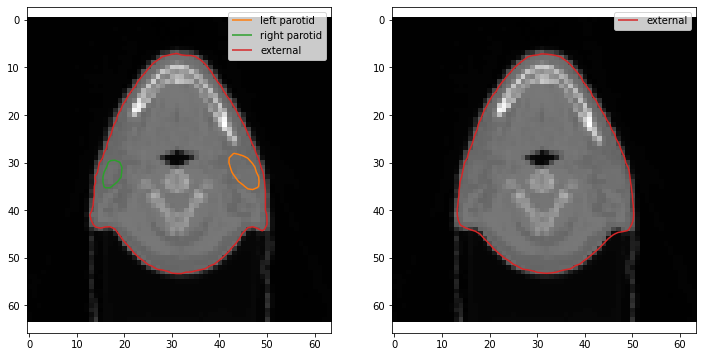


Sample Prediction after epoch 31

Epoch 32/50
4/4 [==============================] - 4s 1s/step - loss: 0.0327 - binary_accuracy: 0.9781 - recall: 0.8997 - precision: 0.9965 - val_loss: 0.0315 - val_binary_accuracy: 0.9786 - val_recall: 0.9038 - val_precision: 0.9959


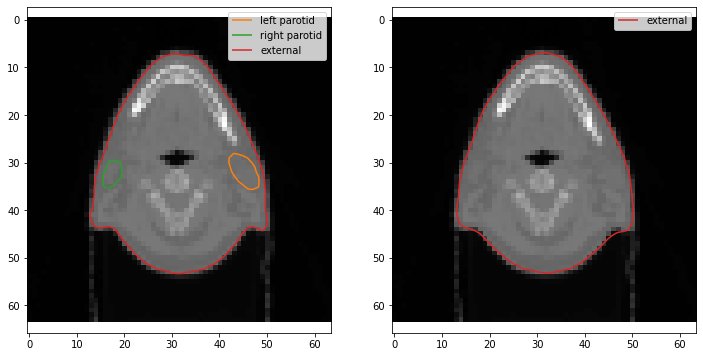


Sample Prediction after epoch 32

Epoch 33/50
4/4 [==============================] - 4s 1s/step - loss: 0.0310 - binary_accuracy: 0.9782 - recall: 0.9006 - precision: 0.9967 - val_loss: 0.0298 - val_binary_accuracy: 0.9786 - val_recall: 0.9065 - val_precision: 0.9958


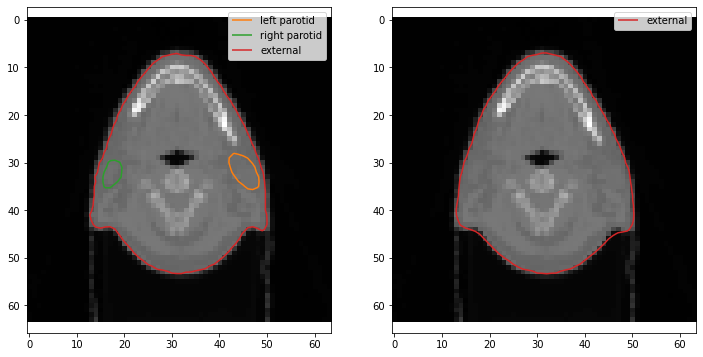


Sample Prediction after epoch 33

Epoch 34/50
4/4 [==============================] - 4s 1s/step - loss: 0.0293 - binary_accuracy: 0.9782 - recall: 0.9027 - precision: 0.9967 - val_loss: 0.0281 - val_binary_accuracy: 0.9787 - val_recall: 0.9046 - val_precision: 0.9962


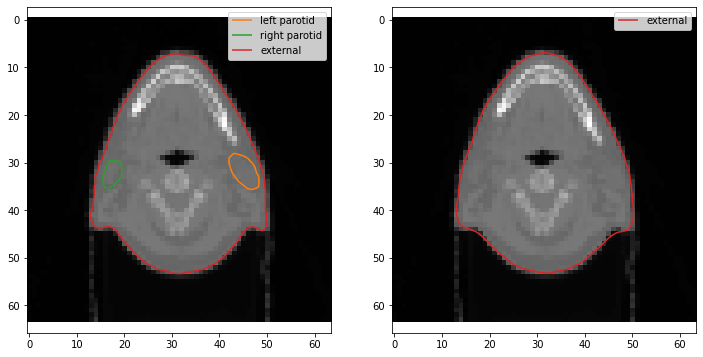


Sample Prediction after epoch 34

Epoch 35/50
4/4 [==============================] - 4s 1s/step - loss: 0.0273 - binary_accuracy: 0.9783 - recall: 0.9025 - precision: 0.9969 - val_loss: 0.0267 - val_binary_accuracy: 0.9788 - val_recall: 0.9054 - val_precision: 0.9962


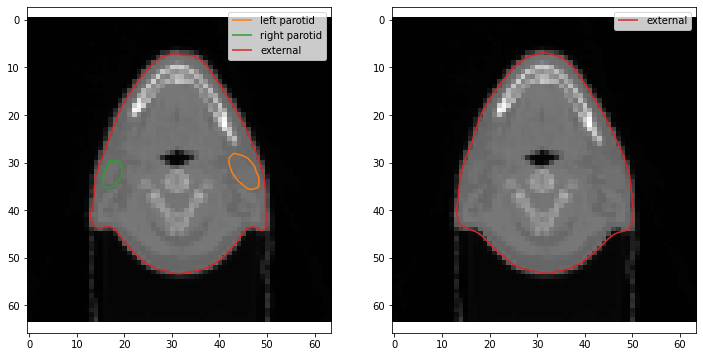


Sample Prediction after epoch 35

Epoch 36/50
4/4 [==============================] - 4s 1s/step - loss: 0.0260 - binary_accuracy: 0.9784 - recall: 0.9027 - precision: 0.9964 - val_loss: 0.0261 - val_binary_accuracy: 0.9788 - val_recall: 0.9118 - val_precision: 0.9923


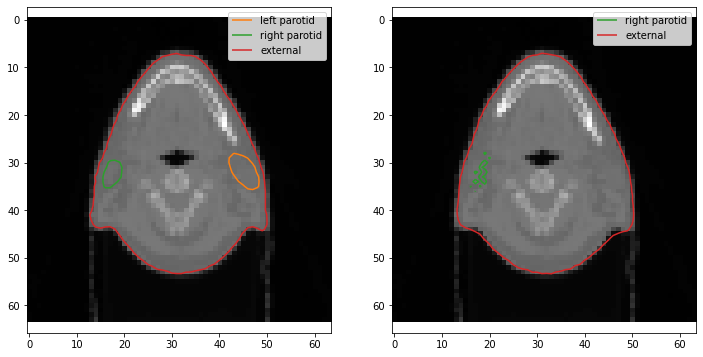


Sample Prediction after epoch 36

Epoch 37/50
4/4 [==============================] - 4s 1s/step - loss: 0.0252 - binary_accuracy: 0.9784 - recall: 0.9042 - precision: 0.9955 - val_loss: 0.0245 - val_binary_accuracy: 0.9789 - val_recall: 0.9044 - val_precision: 0.9964


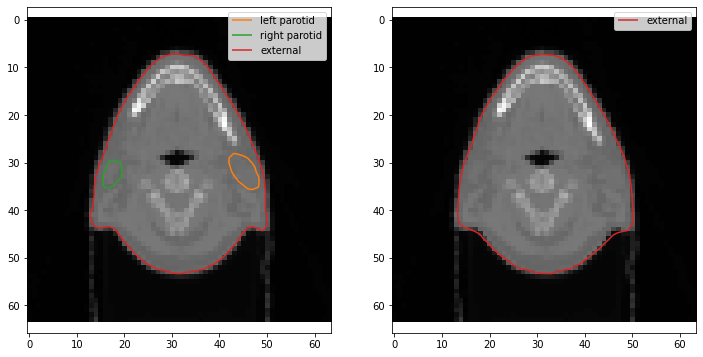


Sample Prediction after epoch 37

Epoch 38/50
4/4 [==============================] - 4s 1s/step - loss: 0.0237 - binary_accuracy: 0.9785 - recall: 0.9018 - precision: 0.9971 - val_loss: 0.0233 - val_binary_accuracy: 0.9789 - val_recall: 0.9013 - val_precision: 0.9972


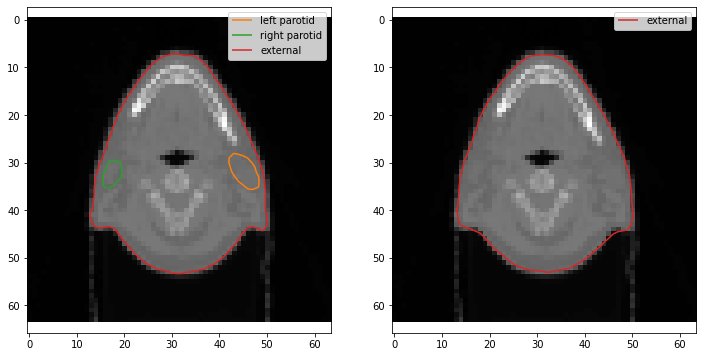


Sample Prediction after epoch 38

Epoch 39/50
4/4 [==============================] - 4s 1s/step - loss: 0.0225 - binary_accuracy: 0.9787 - recall: 0.9032 - precision: 0.9969 - val_loss: 0.0223 - val_binary_accuracy: 0.9794 - val_recall: 0.9139 - val_precision: 0.9955


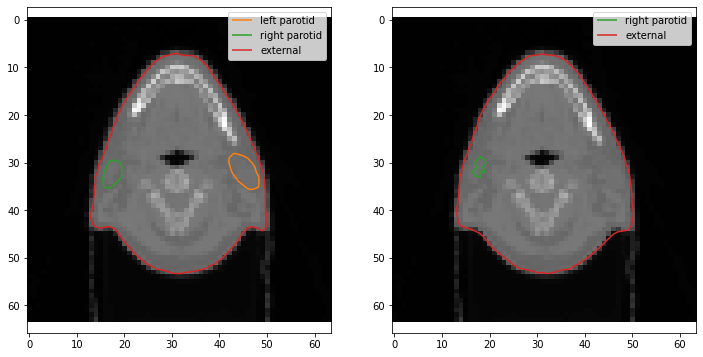


Sample Prediction after epoch 39

Epoch 40/50
4/4 [==============================] - 4s 1s/step - loss: 0.0218 - binary_accuracy: 0.9788 - recall: 0.9115 - precision: 0.9934 - val_loss: 0.0216 - val_binary_accuracy: 0.9792 - val_recall: 0.9057 - val_precision: 0.9970


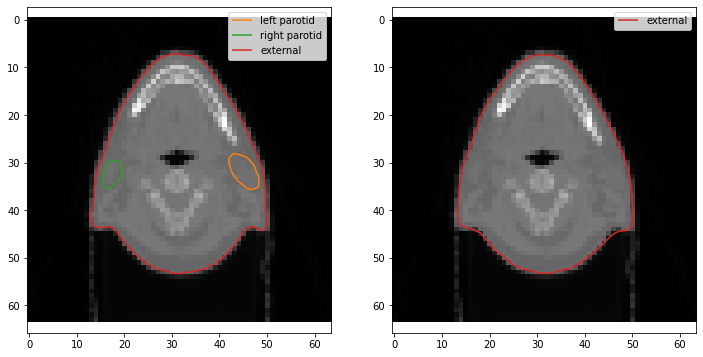


Sample Prediction after epoch 40

Epoch 41/50
4/4 [==============================] - 4s 1s/step - loss: 0.0209 - binary_accuracy: 0.9789 - recall: 0.9056 - precision: 0.9966 - val_loss: 0.0208 - val_binary_accuracy: 0.9796 - val_recall: 0.9124 - val_precision: 0.9947


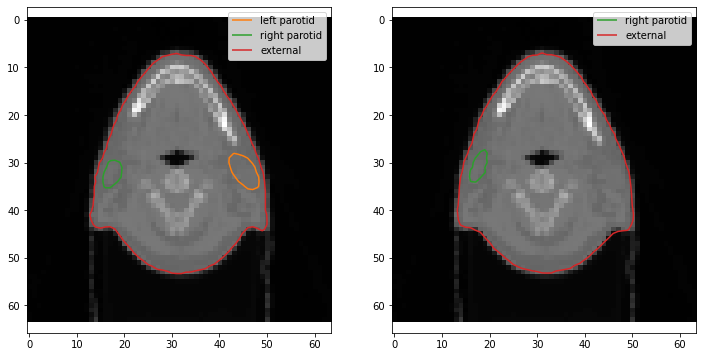


Sample Prediction after epoch 41

Epoch 42/50
4/4 [==============================] - 4s 1s/step - loss: 0.0201 - binary_accuracy: 0.9792 - recall: 0.9092 - precision: 0.9954 - val_loss: 0.0209 - val_binary_accuracy: 0.9797 - val_recall: 0.9083 - val_precision: 0.9967


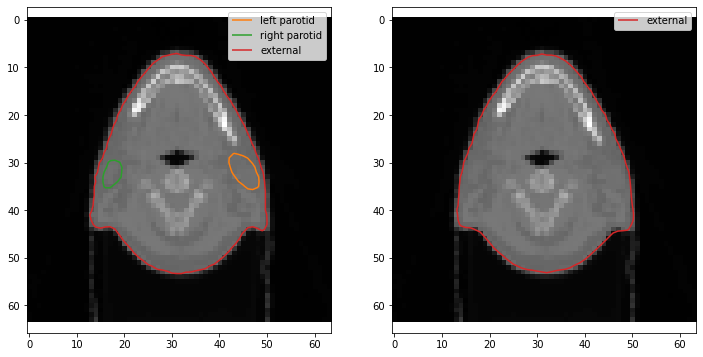


Sample Prediction after epoch 42

Epoch 43/50
4/4 [==============================] - 4s 1s/step - loss: 0.0207 - binary_accuracy: 0.9792 - recall: 0.9107 - precision: 0.9955 - val_loss: 0.0206 - val_binary_accuracy: 0.9796 - val_recall: 0.9157 - val_precision: 0.9906


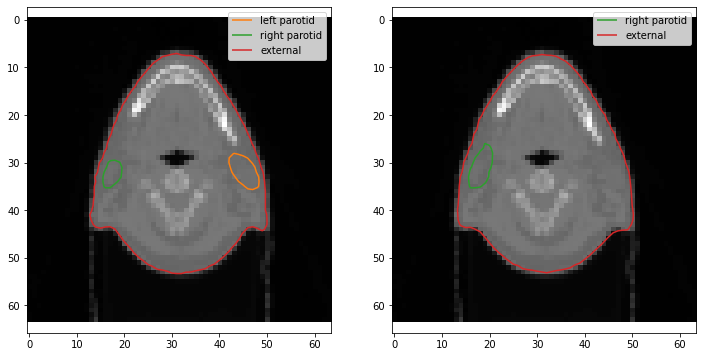


Sample Prediction after epoch 43

Epoch 44/50
4/4 [==============================] - 4s 1s/step - loss: 0.0198 - binary_accuracy: 0.9794 - recall: 0.9120 - precision: 0.9942 - val_loss: 0.0198 - val_binary_accuracy: 0.9802 - val_recall: 0.9130 - val_precision: 0.9944


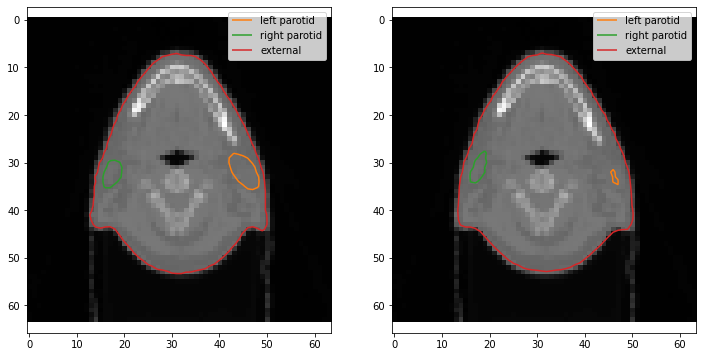


Sample Prediction after epoch 44

Epoch 45/50
4/4 [==============================] - 4s 1s/step - loss: 0.0191 - binary_accuracy: 0.9798 - recall: 0.9172 - precision: 0.9936 - val_loss: 0.0196 - val_binary_accuracy: 0.9803 - val_recall: 0.9203 - val_precision: 0.9950


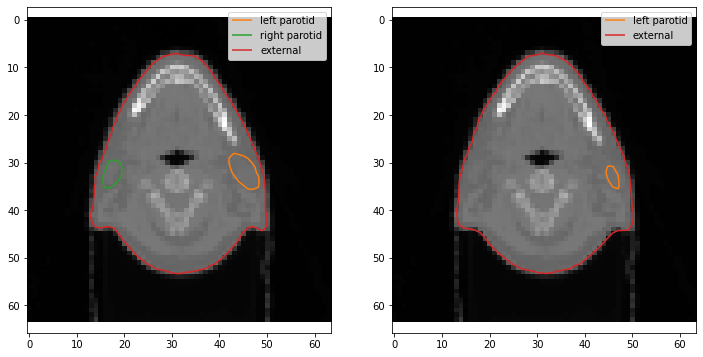


Sample Prediction after epoch 45

Epoch 46/50
4/4 [==============================] - 4s 1s/step - loss: 0.0185 - binary_accuracy: 0.9800 - recall: 0.9219 - precision: 0.9932 - val_loss: 0.0192 - val_binary_accuracy: 0.9805 - val_recall: 0.9305 - val_precision: 0.9908


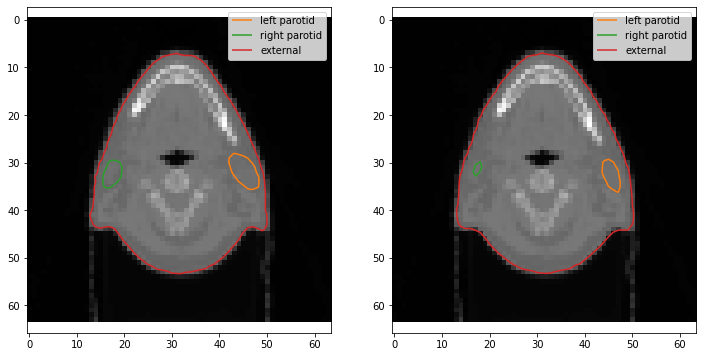


Sample Prediction after epoch 46

Epoch 47/50
4/4 [==============================] - 4s 1s/step - loss: 0.0183 - binary_accuracy: 0.9802 - recall: 0.9251 - precision: 0.9925 - val_loss: 0.0190 - val_binary_accuracy: 0.9805 - val_recall: 0.9288 - val_precision: 0.9889


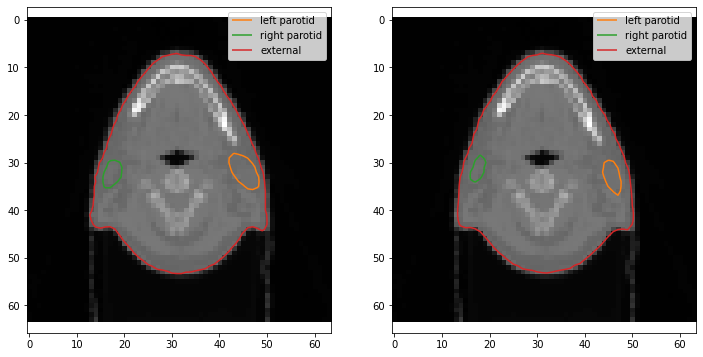


Sample Prediction after epoch 47

Epoch 48/50
4/4 [==============================] - 4s 1s/step - loss: 0.0181 - binary_accuracy: 0.9802 - recall: 0.9251 - precision: 0.9920 - val_loss: 0.0186 - val_binary_accuracy: 0.9806 - val_recall: 0.9205 - val_precision: 0.9947


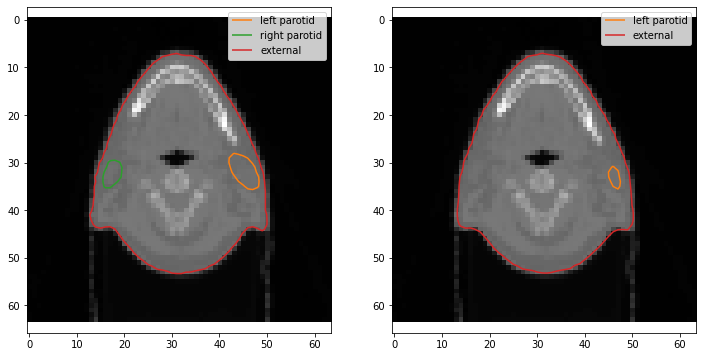


Sample Prediction after epoch 48

Epoch 49/50
4/4 [==============================] - 4s 1s/step - loss: 0.0176 - binary_accuracy: 0.9804 - recall: 0.9223 - precision: 0.9943 - val_loss: 0.0183 - val_binary_accuracy: 0.9808 - val_recall: 0.9293 - val_precision: 0.9932


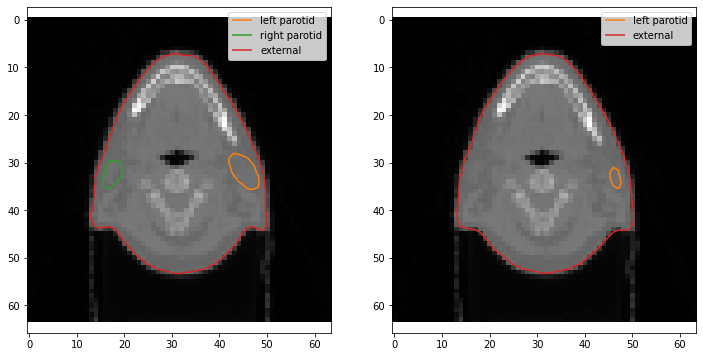


Sample Prediction after epoch 49

Epoch 50/50
4/4 [==============================] - 4s 1s/step - loss: 0.0174 - binary_accuracy: 0.9805 - recall: 0.9267 - precision: 0.9930 - val_loss: 0.0207 - val_binary_accuracy: 0.9791 - val_recall: 0.9361 - val_precision: 0.9752


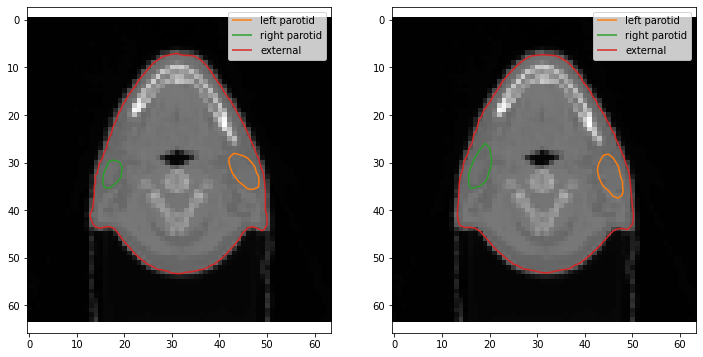


Sample Prediction after epoch 50



In [50]:
history = model.fit(
    datasets["training"],
    epochs=50,
    validation_data=datasets["validation"],
    callbacks=[DisplayCallback()],
)

In [51]:
# Compare the training results. Sometimes it won't converge.
# Can re-initialise the model and re-train in that case.

## BREAKOUT ROOMS ##
# -- Goal: Catch everyone up, and have everyone be able to train a UNet

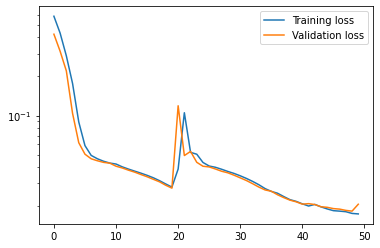

In [52]:
plt.semilogy(history.history["loss"], label="Training loss")
plt.semilogy(
    history.history["val_loss"],
    label="Validation loss",
)
plt.legend()